## Overview

This notebook explores the Datafiniti Hotel Reviews dataset provided on [Kaggle](https://www.kaggle.com/datafiniti/hotel-reviews)

In [110]:
# Data processing
import pandas as pd
from urllib.parse import urlparse
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# ML modeling
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from wordcloud import WordCloud
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
import gensim
import gensim.corpora as corpora
from pprint import pprint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\njeri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\njeri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\njeri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [98]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load data

In [2]:
df_1 = pd.read_csv('data/Datafiniti_Hotel_Reviews.csv')
df_1.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10000, 25)

In [3]:
df_2 = pd.read_csv('data/Datafiniti_Hotel_Reviews_Jun19.csv')
df_2.columns

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'sourceURLs', 'websites'],
      dtype='object')

In [4]:
# Make sure columns match before concatenating
df_2 = df_2.drop(columns='reviews.dateAdded')
df_2.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10000, 25)

In [5]:
data = pd.concat([df_1, df_2], ignore_index=True)
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(20000, 25)

In [6]:
data.head(3)

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-02T00:00:00Z,2016-08-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-11-15T00:00:00Z,2016-08-23T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com


In [7]:
data.columns

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateSeen',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs', 'websites'],
      dtype='object')

## Look for missing values

In [8]:
data.isnull().sum()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id                         0
dateAdded                  0
dateUpdated                0
address                    0
categories                 0
primaryCategories          0
city                       0
country                    0
keys                       0
latitude                   0
longitude                  0
name                       0
postalCode                 0
province                   0
reviews.date               0
reviews.dateSeen           0
reviews.rating             0
reviews.sourceURLs         0
reviews.text               1
reviews.title              2
reviews.userCity        5836
reviews.userProvince    7297
reviews.username           0
sourceURLs                 0
websites                   0
dtype: int64

In [9]:
# ~30% or more of data missing
data = data.drop(columns=['reviews.userCity', 'reviews.userProvince'])
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(20000, 23)

In [10]:
data.isnull().sum()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id                    0
dateAdded             0
dateUpdated           0
address               0
categories            0
primaryCategories     0
city                  0
country               0
keys                  0
latitude              0
longitude             0
name                  0
postalCode            0
province              0
reviews.date          0
reviews.dateSeen      0
reviews.rating        0
reviews.sourceURLs    0
reviews.text          1
reviews.title         2
reviews.username      0
sourceURLs            0
websites              0
dtype: int64

In [11]:
# NLP of reviews therefore drop missing reviews
data = data.dropna()
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19997, 23)

## Handle time data

- dateAdded is date info was added to Datafiniti - not needed for this exercise
- remove dateUpdated column
- remove dateAdded column
- remove reviews.dateSeen - not needed for this exercise
- convert review.date to date/time dtype:
    - parse month and year to separate columns
    - create season column

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19997 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  19997 non-null  object 
 1   dateAdded           19997 non-null  object 
 2   dateUpdated         19997 non-null  object 
 3   address             19997 non-null  object 
 4   categories          19997 non-null  object 
 5   primaryCategories   19997 non-null  object 
 6   city                19997 non-null  object 
 7   country             19997 non-null  object 
 8   keys                19997 non-null  object 
 9   latitude            19997 non-null  float64
 10  longitude           19997 non-null  float64
 11  name                19997 non-null  object 
 12  postalCode          19997 non-null  object 
 13  province            19997 non-null  object 
 14  reviews.date        19997 non-null  object 
 15  reviews.dateSeen    19997 non-null  object 
 16  revi

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
data = data.drop(columns=['dateAdded', 'dateUpdated', 'reviews.dateSeen'])
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19997, 20)

In [14]:
data['reviews.date'] = pd.to_datetime(data['reviews.date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19997 entries, 0 to 19999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  19997 non-null  object             
 1   address             19997 non-null  object             
 2   categories          19997 non-null  object             
 3   primaryCategories   19997 non-null  object             
 4   city                19997 non-null  object             
 5   country             19997 non-null  object             
 6   keys                19997 non-null  object             
 7   latitude            19997 non-null  float64            
 8   longitude           19997 non-null  float64            
 9   name                19997 non-null  object             
 10  postalCode          19997 non-null  object             
 11  province            19997 non-null  object             
 12  reviews.date        19997 non-nu

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
data['month'] = data['reviews.date'].dt.month
data['year'] = data['reviews.date'].dt.year
data.head()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,address,categories,primaryCategories,city,country,keys,latitude,longitude,name,...,reviews.date,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,websites,month,year
0,AVwc252WIN2L1WUfpqLP,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,-117.186136,Rancho Valencia Resort Spa,...,2013-11-14 00:00:00+00:00,5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,11,2013
1,AVwc252WIN2L1WUfpqLP,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,-117.186136,Rancho Valencia Resort Spa,...,2014-07-06 00:00:00+00:00,5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,7,2014
2,AVwc252WIN2L1WUfpqLP,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,-117.186136,Rancho Valencia Resort Spa,...,2015-01-02 00:00:00+00:00,5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,1,2015
3,AVwdOclqIN2L1WUfti38,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,-76.716341,Aloft Arundel Mills,...,2016-05-15 00:00:00+00:00,2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,5,2016
4,AVwdOclqIN2L1WUfti38,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,-76.716341,Aloft Arundel Mills,...,2016-07-09 00:00:00+00:00,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,7,2016


In [16]:
data = data.drop(columns='reviews.date')
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19997, 21)

In [17]:
def season(month):
    if month >= 1 and month <= 2:
        return 'winter'
    if month >= 3 and month <= 5:
        return 'spring'
    if month >= 6 and month <= 8:
        return 'summer'
    if month >= 9 and month <= 11:
        return 'fall'
    if month == 12:
        return 'winter'

data['visit_season'] = data['month'].map(season)
data.tail()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,address,categories,primaryCategories,city,country,keys,latitude,longitude,name,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,websites,month,year,visit_season
19995,AVwdatg0ByjofQCxo5S5,3101 Coliseum Dr,"Hotels,Hotels and motels,Corporate Lodging,New...",Accommodation & Food Services,Hampton,US,us/va/hampton/3101coliseumdr/-1319580369,37.057650,-76.393310,Hampton Inn Hampton-newport News,...,4.0,http://www.tripadvisor.com/Hotel_Review-g57804...,My friends and I took a trip to Hampton for th...,Very accommodating and friendly staff!,Tiffany1017,https://www.tripadvisor.com/Hotel_Review-g5780...,https://ad.doubleclick.net/ddm/clk/317271033;1...,12,2015,winter
19996,AVwdatg0ByjofQCxo5S5,3101 Coliseum Dr,"Hotels,Hotels and motels,Corporate Lodging,New...",Accommodation & Food Services,Hampton,US,us/va/hampton/3101coliseumdr/-1319580369,37.057650,-76.393310,Hampton Inn Hampton-newport News,...,5.0,http://www.tripadvisor.com/Hotel_Review-g57804...,"from check in to departure, staff is friendly,...","comfortable, friendly, clean, professional",bobg187,https://www.tripadvisor.com/Hotel_Review-g5780...,https://ad.doubleclick.net/ddm/clk/317271033;1...,11,2015,fall
19997,AVwdatg0ByjofQCxo5S5,3101 Coliseum Dr,"Hotels,Hotels and motels,Corporate Lodging,New...",Accommodation & Food Services,Hampton,US,us/va/hampton/3101coliseumdr/-1319580369,37.057650,-76.393310,Hampton Inn Hampton-newport News,...,5.0,https://www.tripadvisor.com/Hotel_Review-g5780...,This Hampton is located on a quiet street acro...,Great location,K261ANbrendah,https://www.tripadvisor.com/Hotel_Review-g5780...,https://ad.doubleclick.net/ddm/clk/317271033;1...,7,2016,summer
19998,AV1thTgM3-Khe5l_OvT5,7886 Main Street,"Hotels,Bar,Hotel,Restaurants",Accommodation & Food Services,Hunter,US,us/ny/hunter/7886mainstreet/-435384771,42.210915,-74.215309,Roseberry's Inn,...,5.0,https://www.tripadvisor.com/Hotel_Review-g4793...,Awesome wings (my favorite was garlic parmesan...,Great Atmosphere!,soccerrocks2016,https://www.bbb.org/us/ny/hunter/profile/hotel...,http://www.roseberrysinnhunter.com/,10,2016,fall
19999,AV1tg9C7a4HuVbed8XA5,3505 S Main St,"Hotels,Hotels and motels,Corporate Lodging,Lod...",Accommodation & Food Services,Lindale,US,us/tx/lindale/3505smainst/-147603681,32.469540,-95.390420,Hampton Inn-lindale/tyler,...,4.0,http://tripadvisor.com/Hotel_Review-g56167-d22...,Clean facility just off freeway ..... staff fr...,Health care appointments,tootallsmith,https://www.yellowpages.com/lindale-tx/mip/ham...,http://hamptoninn3.hilton.com/en/hotels/texas/...,6,2017,summer


## Explore each column

In [18]:
data.id.nunique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2975

In [19]:
data.address.nunique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2970

In [20]:
data.categories.nunique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1652

In [21]:
data.primaryCategories.unique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Accommodation & Food Services',
       'Healthcare & Social Assistance,Accommodation & Food Services',
       'Accommodation & Food Services,Arts Entertainment & Recreation',
       'Arts Entertainment & Recreation',
       'Wholesale Trade,Accommodation & Food Services', 'Utilities',
       'Accommodation & Food Services,Administrative & Support & Waste Management & Remediation',
       'Accommodation & Food Services,Agriculture'], dtype=object)

In [22]:
data.city.nunique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1416

In [23]:
data.country.nunique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1

In [24]:
# All reviews in US
data = data.drop(columns='country')
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19997, 21)

In [25]:
data['keys'].nunique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2976

In [26]:
data.name.nunique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2764

In [27]:
data.province.nunique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


50

In [28]:
data['reviews.rating'].unique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([5.  , 2.  , 4.  , 3.  , 1.  , 4.8 , 4.6 , 3.55, 4.4 , 4.15, 2.5 ,
       3.95, 2.9 , 3.35, 3.75, 4.5 , 2.1 , 1.65, 3.15, 2.7 , 1.45, 2.75,
       2.3 , 3.5 , 4.25, 1.25, 1.9 , 3.45, 3.25, 4.75])

In [29]:
# Change reviews to categories rather than numbers
def review_map(rating):
    if rating == 5:
        return 'great'
    if rating >=4 and rating < 5:
        return 'good'
    if rating < 4:
        return 'not great'

data['cat_rating'] = data['reviews.rating'].map(review_map)
data['cat_rating'].tail()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


19995     good
19996    great
19997    great
19998    great
19999     good
Name: cat_rating, dtype: object

In [30]:
data['reviews.sourceURLs'].nunique()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14256

In [31]:
def short_url(url):
    parsed = urlparse(url)
    short_url = parsed.netloc
    return short_url.replace('www.', '')

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
data['short_source'] = data['reviews.sourceURLs'].map(short_url)
data['short_source'].tail()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


19995    tripadvisor.com
19996    tripadvisor.com
19997    tripadvisor.com
19998    tripadvisor.com
19999    tripadvisor.com
Name: short_source, dtype: object

In [33]:
# drop long URLs for modeling
data = data.drop(columns=['sourceURLs', 'websites'])
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19997, 21)

In [34]:
data.columns

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['id', 'address', 'categories', 'primaryCategories', 'city', 'keys',
       'latitude', 'longitude', 'name', 'postalCode', 'province',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.username', 'month', 'year', 'visit_season', 'cat_rating',
       'short_source'],
      dtype='object')

----------------------------------------------------

- ID is unique identifier for hotel
- remove address column - city, state, lat/lon sufficient for location information
- remove keys column - not needed for this exercise
- split reviews.date to month & date of review and add season
- remove reviews.sourceURLs since short URLs created

-----------------------------------------

In [35]:
data = data.drop(columns=['address', 'keys', 'reviews.sourceURLs'])
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19997, 18)

In [36]:
data['cat_rating'].value_counts()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


great        9223
good         5749
not great    5025
Name: cat_rating, dtype: int64

In [37]:
data['visit_season'].value_counts()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


summer    6177
spring    5338
fall      4537
winter    3945
Name: visit_season, dtype: int64

In [38]:
data['primaryCategories'].value_counts()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accommodation & Food Services                                                              19916
Arts Entertainment & Recreation                                                               45
Healthcare & Social Assistance,Accommodation & Food Services                                  18
Accommodation & Food Services,Arts Entertainment & Recreation                                  8
Wholesale Trade,Accommodation & Food Services                                                  7
Accommodation & Food Services,Administrative & Support & Waste Management & Remediation        1
Accommodation & Food Services,Agriculture                                                      1
Utilities                                                                                      1
Name: primaryCategories, dtype: int64

In [39]:
data['year'].value_counts()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2016    6916
2015    4618
2017    2508
2014    1652
2018    1269
2013    1135
2012     692
2011     418
2010     223
2009     167
2007     135
2008     122
2006      42
2019      40
2005      32
2004      22
2003       5
2002       1
Name: year, dtype: int64

---------------------------------------

- Remove primaryCategories column - all categories can be considered accommodation & food services
- Remove reviews.username - not applicaple for aggregation

---------------------------------------

In [40]:
data = data.drop(columns=['primaryCategories', 'reviews.username'])
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19997, 16)

## Process text columns

✅ pip install NLTK <br>
✅ create functions in data.py to clean text:<br>
- remove numbers
- remove punctuation
- convert all text to lower case
- remove stopwords
- lemmatize words <br>

✅ add any functions used in cleaning data above to data.py & create classes <br>
✅ create review_richness column (i.e introduce vocabulary richness feature) <br>
✅ add richness functions to data.py <br>
✅ test data.py

In [41]:
def punc_remover(df, new_col, old_col):
    df[new_col] = df[old_col]
    for punctuation in string.punctuation:
        df[new_col] = df[new_col].map(lambda x: x.replace(punctuation, '')) 
    return df

def lower_case(df, new_col):
    df[new_col] = df[new_col].map(lambda x: x.lower())
    return df

def remove_num(df, new_col):
    df[new_col] = df[new_col].map(lambda x: ''.join(word for word in x if not word.isdigit()))
    return df

def remove_stop(df, new_col):
    stop_words = set(stopwords.words('english')) 
    df[new_col] = df[new_col].map(word_tokenize) 
    df[new_col] = df[new_col].map(lambda x: ' '.join(w for w in x if not w in stop_words))
    return df

def lemmatize(df, new_col):
    df[new_col] = df[new_col].map(word_tokenize)
    lemmatizer = WordNetLemmatizer()
    df[new_col] = df[new_col].map(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x))
    return df

def proc_text(df, new_col, old_col):
    punc_remover(df, new_col, old_col)
    lower_case(df, new_col)
    remove_num(df, new_col)
    remove_stop(df, new_col)
    lemmatize(df, new_col)
    df = df.drop(columns=old_col, inplace=True)
    return df

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
data.columns

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['id', 'categories', 'city', 'latitude', 'longitude', 'name',
       'postalCode', 'province', 'reviews.rating', 'reviews.text',
       'reviews.title', 'month', 'year', 'visit_season', 'cat_rating',
       'short_source'],
      dtype='object')

In [43]:
# Process categories column
proc_text(data, 'clean_categories', 'categories')
data.head()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,city,latitude,longitude,name,postalCode,province,reviews.rating,reviews.text,reviews.title,month,year,visit_season,cat_rating,short_source,clean_categories
0,AVwc252WIN2L1WUfpqLP,Rancho Santa Fe,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,5.0,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,11,2013,fall,great,hotels.com,hotelshotels motelshotel motel reservationsres...
1,AVwc252WIN2L1WUfpqLP,Rancho Santa Fe,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,5.0,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,7,2014,summer,great,hotels.com,hotelshotels motelshotel motel reservationsres...
2,AVwc252WIN2L1WUfpqLP,Rancho Santa Fe,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,5.0,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,1,2015,winter,great,hotels.com,hotelshotels motelshotel motel reservationsres...
3,AVwdOclqIN2L1WUfti38,Hanover,39.155929,-76.716341,Aloft Arundel Mills,21076,MD,2.0,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",5,2016,spring,not great,tripadvisor.com,hotelshotels motelstravel agency bureaushotel ...
4,AVwdOclqIN2L1WUfti38,Hanover,39.155929,-76.716341,Aloft Arundel Mills,21076,MD,5.0,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,7,2016,summer,great,tripadvisor.com,hotelshotels motelstravel agency bureaushotel ...


In [44]:
# Process remaining text columns
proc_text(data, 'clean_city', 'city')
proc_text(data, 'clean_state', 'province')
proc_text(data, 'clean_title', 'reviews.title')
proc_text(data, 'clean_review', 'reviews.text')
proc_text(data, 'clean_name', 'name')
data.head()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,latitude,longitude,postalCode,reviews.rating,month,year,visit_season,cat_rating,short_source,clean_categories,clean_city,clean_state,clean_title,clean_review,clean_name
0,AVwc252WIN2L1WUfpqLP,32.990959,-117.186136,92067,5.0,11,2013,fall,great,hotels.com,hotelshotels motelshotel motel reservationsres...,rancho santa fe,ca,best romantic vacation ever,experience rancho valencia absolutely perfect ...,rancho valencia resort spa
1,AVwc252WIN2L1WUfpqLP,32.990959,-117.186136,92067,5.0,7,2014,summer,great,hotels.com,hotelshotels motelshotel motel reservationsres...,rancho santa fe,ca,sweet sweet serenity,amazing place everyone extremely warm welcomin...,rancho valencia resort spa
2,AVwc252WIN2L1WUfpqLP,32.990959,-117.186136,92067,5.0,1,2015,winter,great,hotels.com,hotelshotels motelshotel motel reservationsres...,rancho santa fe,ca,amazing property experience,booked night stay rancho valencia play tennis ...,rancho valencia resort spa
3,AVwdOclqIN2L1WUfti38,39.155929,-76.716341,21076,2.0,5,2016,spring,not great,tripadvisor.com,hotelshotels motelstravel agency bureaushotel ...,hanover,md,never againbeware want sleep,currently bed writing past hr dog barking sque...,aloft arundel mill
4,AVwdOclqIN2L1WUfti38,39.155929,-76.716341,21076,5.0,7,2016,summer,great,tripadvisor.com,hotelshotels motelstravel agency bureaushotel ...,hanover,md,always great stay,live md aloft home away homewe stayed night st...,aloft arundel mill


In [45]:
data.head()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,latitude,longitude,postalCode,reviews.rating,month,year,visit_season,cat_rating,short_source,clean_categories,clean_city,clean_state,clean_title,clean_review,clean_name
0,AVwc252WIN2L1WUfpqLP,32.990959,-117.186136,92067,5.0,11,2013,fall,great,hotels.com,hotelshotels motelshotel motel reservationsres...,rancho santa fe,ca,best romantic vacation ever,experience rancho valencia absolutely perfect ...,rancho valencia resort spa
1,AVwc252WIN2L1WUfpqLP,32.990959,-117.186136,92067,5.0,7,2014,summer,great,hotels.com,hotelshotels motelshotel motel reservationsres...,rancho santa fe,ca,sweet sweet serenity,amazing place everyone extremely warm welcomin...,rancho valencia resort spa
2,AVwc252WIN2L1WUfpqLP,32.990959,-117.186136,92067,5.0,1,2015,winter,great,hotels.com,hotelshotels motelshotel motel reservationsres...,rancho santa fe,ca,amazing property experience,booked night stay rancho valencia play tennis ...,rancho valencia resort spa
3,AVwdOclqIN2L1WUfti38,39.155929,-76.716341,21076,2.0,5,2016,spring,not great,tripadvisor.com,hotelshotels motelstravel agency bureaushotel ...,hanover,md,never againbeware want sleep,currently bed writing past hr dog barking sque...,aloft arundel mill
4,AVwdOclqIN2L1WUfti38,39.155929,-76.716341,21076,5.0,7,2016,summer,great,tripadvisor.com,hotelshotels motelstravel agency bureaushotel ...,hanover,md,always great stay,live md aloft home away homewe stayed night st...,aloft arundel mill


In [46]:
data.loc[data['clean_review'] == '']

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,latitude,longitude,postalCode,reviews.rating,month,year,visit_season,cat_rating,short_source,clean_categories,clean_city,clean_state,clean_title,clean_review,clean_name
5805,AV48ic48a4HuVbedAUNM,38.89089,-77.073860,22209,5.0,5,2008,spring,great,expedia.com,hotelslodginghotelhotels motel,arlington,va,nice place stay,,virginian suite ascend hotel collection member
6198,AVwd0HO5ByjofQCxsvv8,33.70112,-84.098459,30038,5.0,6,2016,summer,great,hotels.com,hotelhotels,lithonia,ga,nice hotel,,hyatt place atlantaeastlithonia


In [47]:
data = data[data.clean_review != '']
data.shape

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19995, 16)

In [48]:
test = data.clean_review[0]
tokens = word_tokenize(test)
length = len(tokens)
unique = set(tokens)
unique_ct = len(unique)
richness = unique_ct/length
richness

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.0

In [49]:
def vocab_richness(text):
    tokens = word_tokenize(text)
    total_length = len(tokens)
    unique_words = set(tokens)
    unique_word_length = len(unique_words)
    return unique_word_length / total_length

data['review_richness'] = data.clean_review.apply(vocab_richness)
data.head()

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,latitude,longitude,postalCode,reviews.rating,month,year,visit_season,cat_rating,short_source,clean_categories,clean_city,clean_state,clean_title,clean_review,clean_name,review_richness
0,AVwc252WIN2L1WUfpqLP,32.990959,-117.186136,92067,5.0,11,2013,fall,great,hotels.com,hotelshotels motelshotel motel reservationsres...,rancho santa fe,ca,best romantic vacation ever,experience rancho valencia absolutely perfect ...,rancho valencia resort spa,1.000000
1,AVwc252WIN2L1WUfpqLP,32.990959,-117.186136,92067,5.0,7,2014,summer,great,hotels.com,hotelshotels motelshotel motel reservationsres...,rancho santa fe,ca,sweet sweet serenity,amazing place everyone extremely warm welcomin...,rancho valencia resort spa,0.933333
2,AVwc252WIN2L1WUfpqLP,32.990959,-117.186136,92067,5.0,1,2015,winter,great,hotels.com,hotelshotels motelshotel motel reservationsres...,rancho santa fe,ca,amazing property experience,booked night stay rancho valencia play tennis ...,rancho valencia resort spa,0.914894
3,AVwdOclqIN2L1WUfti38,39.155929,-76.716341,21076,2.0,5,2016,spring,not great,tripadvisor.com,hotelshotels motelstravel agency bureaushotel ...,hanover,md,never againbeware want sleep,currently bed writing past hr dog barking sque...,aloft arundel mill,1.000000
4,AVwdOclqIN2L1WUfti38,39.155929,-76.716341,21076,5.0,7,2016,summer,great,tripadvisor.com,hotelshotels motelstravel agency bureaushotel ...,hanover,md,always great stay,live md aloft home away homewe stayed night st...,aloft arundel mill,1.000000


## Machine Learning Methods
✅ vectorize with Tfidf Vectorizer (tune max_df, min_df, max_features, ngram_range) <br>
✅ create pipeline to tune vectorizer and Multinomial Naive Bayes (tune nb_alpha) algorithm together <br>
✅ establish baseline evaluation using DummyClassifier (use accuracy as metric) <br>
✅ use cross-validation, especially due to imbalance in data (mostly good reviews) <br>
✅ visualize reviews text with a word cloud as a baseline for LDA <br>
✅ train an LDA model to extract potential topics <br>
✅ create visualization of extracted topics <br>


### Multinomial Naive Bayes

In [50]:
data.columns

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['id', 'latitude', 'longitude', 'postalCode', 'reviews.rating', 'month',
       'year', 'visit_season', 'cat_rating', 'short_source',
       'clean_categories', 'clean_city', 'clean_state', 'clean_title',
       'clean_review', 'clean_name', 'review_richness'],
      dtype='object')

In [51]:
# text_features = ['short_source', 'visit_season', 'clean_categories', 'clean_city', 'clean_state', 'clean_title', \
#                  'clean_review', 'clean_name']
X = data.clean_review
y = data.cat_rating

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19995 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                19995 non-null  object 
 1   latitude          19995 non-null  float64
 2   longitude         19995 non-null  float64
 3   postalCode        19995 non-null  object 
 4   reviews.rating    19995 non-null  float64
 5   month             19995 non-null  int64  
 6   year              19995 non-null  int64  
 7   visit_season      19995 non-null  object 
 8   cat_rating        19995 non-null  object 
 9   short_source      19995 non-null  object 
 10  clean_categories  19995 non-null  object 
 11  clean_city        19995 non-null  object 
 12  clean_state       19995 non-null  object 
 13  clean_title       19995 non-null  object 
 14  clean_review      19995 non-null  object 
 15  clean_name        19995 non-null  object 
 16  review_richness   19995 non-null  float6

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
%%time
# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

# Set parameters to search
parameters = {
    'tfidf__ngram_range': ((1,1), (2,2), (3,3)),
    'tfidf__max_df':(0.7, 0.8, 0.9),
    'tfidf__min_df': (0.1, 0.2, 0.3),
    'tfidf__max_features': (20, 30, 40),
    'nb__alpha': (0.1, 0.5, 1)}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", 
                           refit=True, cv=5)

grid_search.fit(X, y)

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\users\njeri\.venvs\smart_stay\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.49077269        nan        nan 0.48762191        nan        nan
 0.48257064        nan        nan 0.50702676        nan        nan
 0.48762191        nan        nan 0.48257064        nan        nan
 0.51022756        nan        nan 0.48762191        nan        nan
 0.48257064        nan        nan 0.49077269        nan        nan
 0.48762191        nan        nan 0.48257064        nan        nan
 0.50702676        nan        nan 0.48762191        nan        nan
 0.48257064        nan        nan 0.51022756        nan        nan
 0.48762191        nan        nan 0.48257064        nan        nan
 0.49077269        nan        nan 0.48762191        nan        nan
 0.48257064        nan        nan 0.50702676        nan        nan
 0.48762191        nan        nan 0.48257064        nan        nan
 0.51022756        nan        nan 0.48762191 

Wall time: 8min 41s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': (0.1, 0.5, 1),
                         'tfidf__max_df': (0.7, 0.8, 0.9),
                         'tfidf__max_features': (20, 30, 40),
                         'tfidf__min_df': (0.1, 0.2, 0.3),
                         'tfidf__ngram_range': ((1, 1), (2, 2), (3, 3))},
             scoring='accuracy', verbose=1)

In [54]:
grid_search.best_params_

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'nb__alpha': 0.1,
 'tfidf__max_df': 0.7,
 'tfidf__max_features': 40,
 'tfidf__min_df': 0.1,
 'tfidf__ngram_range': (1, 1)}

In [55]:
grid_search.best_score_

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5102275568892223

In [56]:
%%time
# Tune grid search

parameters_2 = {
    'tfidf__ngram_range': [(1,1)],
    'tfidf__max_df':(0.5, 0.6, 0.7),
    'tfidf__min_df': [0.1],
    'tfidf__max_features': (40, 50, 60),
    'nb__alpha': [0.1]}

# Perform grid search
grid_search_2 = GridSearchCV(pipeline, parameters_2, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", 
                           refit=True, cv=5)

grid_search_2.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 11.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.1], 'tfidf__max_df': (0.5, 0.6, 0.7),
                         'tfidf__max_features': (40, 50, 60),
                         'tfidf__min_df': [0.1],
                         'tfidf__ngram_range': [(1, 1)]},
             scoring='accuracy', verbose=1)

In [57]:
grid_search_2.best_params_

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'nb__alpha': 0.1,
 'tfidf__max_df': 0.7,
 'tfidf__max_features': 50,
 'tfidf__min_df': 0.1,
 'tfidf__ngram_range': (1, 1)}

In [58]:
grid_search_2.best_score_

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5108277069267316

In [59]:
# check with a 4-star review

review = [['This is a great way to get around Hakone. It is included in the Hakone Freepass so why not? On a clear day, it also offers great views of the mountains.']]
review_df = pd.DataFrame(data=review)
proc_text(review_df, 'clean_review', 0)
grid_search_2.predict(review_df.clean_review)

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['great'], dtype='<U9')

In [60]:
# check with a 2-star review

review_2 = [['So I know that when you eat at a diner you are going to get greasy food, but this had way too much grease. We may have just gone on a bad day but the hashbrowns were so greasy that they were soggy (versus crispy), and the scrambled eggs managed to somehow be both undercooked and overly greasy. The only thing that gave this place 2 stars instead of 1 is that our server was great.']]
review_2_df = pd.DataFrame(data=review_2)
proc_text(review_2_df, 'clean_review', 0)
grid_search_2.predict(review_2_df.clean_review)

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['great'], dtype='<U9')

In [61]:
# 1-star review

review_3 = [['The waiters/waitresses seemed to hate their jobs and made it unpleasant to eat/be here. My sandwich wasn’t good, Denver Melt. My husband’s sausage sandwich was tasty. Just disappointed as the ratings were good - definitely not.']]
review_3_df = pd.DataFrame(data=review_3)
proc_text(review_3_df, 'clean_review', 0)
grid_search_2.predict(review_3_df.clean_review)

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['good'], dtype='<U9')

### Baseline evaluation

In [70]:
%%time

pipeline_bl = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.7, max_features=50, min_df=0.1, ngram_range=(1,1))),
    ('dc', DummyClassifier()),
])

parameters_bl = {
    'dc__strategy': ['stratified', 'most_frequent', 'prior']
}

grid_search_bl = GridSearchCV(pipeline_bl, parameters_bl, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", 
                           refit=True, cv=5)

grid_search_bl.fit(X, y)

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 5.34 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.7,
                                                        max_features=50,
                                                        min_df=0.1)),
                                       ('dc', DummyClassifier())]),
             n_jobs=-1,
             param_grid={'dc__strategy': ['stratified', 'most_frequent',
                                          'prior']},
             scoring='accuracy', verbose=1)

In [71]:
grid_search_bl.best_params_

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'dc__strategy': 'most_frequent'}

In [72]:
grid_search_bl.best_score_

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.46116529132283074

In [65]:
print(f'4-star result: {grid_search_bl.predict(review_df.clean_review)}')
print(f'2-star result: {grid_search_bl.predict(review_2_df.clean_review)}')
print(f'1-star result: {grid_search_bl.predict(review_3_df.clean_review)}')

4-star result: ['great']
2-star result: ['great']
1-star result: ['great']


c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-----------------------------------------------------

*Multinomial Naive Bayes is slightly better than the Dummy Classifier on accuracy score and neither does well on predicting ratings from new reviews. Try LDA to see topics can be allocated from the data*

-----------------------------------------------------

### Latent Dirichlet Allocation

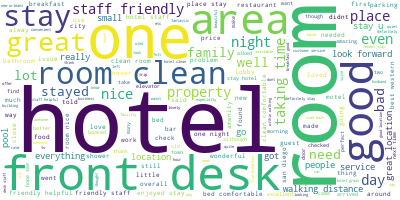

In [102]:
# Generate word cloud

# Join the different processed reviews together.
long_string = ' '.join(list(data['clean_review'].values))

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_file('visualizations/review_cloud.png')
wordcloud.to_image()

In [97]:
# Tokenize words
text = word_tokenize(long_string)

# Create Dictionary
id2word = corpora.Dictionary([text])

# Term Document Frequency
corpus = [id2word.doc2bow([word]) for word in text]

# View
print(corpus[:1][0][:30])

c:\users\njeri\.venvs\smart_stay\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(10938, 1)]


In [100]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"like" + 0.043*"thank" + 0.042*"also" + 0.031*"make" + 0.026*"floor" '
  '+ 0.026*"trip" + 0.020*"thing" + 0.016*"spacious" + 0.015*"issue" + '
  '0.014*"recent"'),
 (1,
  '0.241*"room" + 0.109*"staff" + 0.021*"two" + 0.020*"suite" + '
  '0.020*"manager" + 0.018*"glad" + 0.016*"business" + 0.015*"hot" + '
  '0.015*"downtown" + 0.015*"found"'),
 (2,
  '0.045*"place" + 0.043*"comfortable" + 0.038*"get" + 0.036*"review" + '
  '0.034*"restaurant" + 0.027*"inn" + 0.025*"small" + 0.022*"lot" + '
  '0.022*"little" + 0.021*"property"'),
 (3,
  '0.223*"hotel" + 0.038*"well" + 0.033*"pool" + 0.026*"could" + 0.022*"right" '
  '+ 0.021*"always" + 0.020*"walk" + 0.019*"happy" + 0.019*"door" + '
  '0.019*"walking"'),
 (4,
  '0.079*"nice" + 0.072*"would" + 0.058*"friendly" + 0.042*"day" + '
  '0.042*"guest" + 0.026*"visit" + 0.023*"go" + 0.019*"got" + 0.019*"forward" '
  '+ 0.018*"way"'),
 (5,
  '0.105*"great" + 0.075*"time" + 0.066*"good" + 0.036*"next" + '
  '0.030*"enjoyed" + 0.026*"

----------------------------------------------

#### LDA Visualization with [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html)

- Intertopic Distance Map shows how topics are related to each other
- Top-30 Most Salient terms provides most frequent/relevant terms within a topic. Since LDA is unsupervised, \
    this list can help with drawing meaning or context from a topic
- More about LDA topic modeling [here](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
    
------------------------------------------------

In [106]:
# Visualize LDA output topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('visualizations/ldavis_prepared_'+str(num_topics))

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'visualizations/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.224067  0.221393       1        1  10.373381
7     -0.010637 -0.232174       2        1  10.316920
3     -0.232149  0.174798       3        1  10.299175
2      0.164902  0.127256       4        1  10.212158
5     -0.196835 -0.002971       5        1  10.179623
6      0.067437 -0.139016       6        1   9.986672
9      0.173087 -0.165128       7        1   9.977286
4     -0.048946  0.103688       8        1   9.701702
8     -0.103992 -0.100212       9        1   9.695296
0     -0.036934  0.012365      10        1   9.257788, topic_info=          Term          Freq         Total Category  logprob  loglift
26587     room  22602.000000  22602.000000  Default  30.0000  30.0000
14840    hotel  20766.000000  20766.000000  Default  29.0000  29.0000
29777     stay  12624.000000  12624.000000  Default  28.0000  28.0000
29564    staff  10293.000000  10293.000000  Default  27.0000  27.0000
13414    great   9609.000000   9609.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
33475    valet    752.331083    759.514685  Topic10  -4.7093   2.3702
2562       bad   1160.013717   1227.650116  Topic10  -4.2763   2.3230
2418   awesome    709.652807    717.736377  Topic10  -4.7677   2.3684
10273   entire    703.928781    711.734521  Topic10  -4.7758   2.3687
31440    think    689.265095    696.408161  Topic10  -4.7968   2.3694

[481 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
38         6  0.002017    able
38         8  0.000672    able
38         9  0.997091    able
134        2  0.002395  access
134        3  0.001197  access
...      ...       ...     ...
35219      9  0.000157   would
35270      1  0.002045   write
35270      9  0.998163   write
35373      5  0.000754    year
35373      7  0.998574    year

[1427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 4, 3, 6, 7, 10, 5, 9, 1])

In [104]:
# Try with more topics

# number of topics
num_topics_2 = 20

# Build LDA model
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics_2)

# Print the Keyword in the 10 topics
pprint(lda_model_2.print_topics())
doc_lda_2 = lda_model_2[corpus]

[(0,
  '0.719*"staff" + 0.094*"sure" + 0.023*"done" + 0.015*"third" + '
  '0.011*"despite" + 0.002*"treatment" + 0.001*"teacoffee" + 0.000*"drainage" '
  '+ 0.000*"good" + 0.000*"room"'),
 (1,
  '0.147*"youre" + 0.121*"ready" + 0.094*"chance" + 0.083*"central" + '
  '0.053*"information" + 0.018*"luckily" + 0.007*"structure" + '
  '0.006*"manhattan" + 0.001*"vine" + 0.000*"room"'),
 (2,
  '0.412*"time" + 0.111*"wonderful" + 0.109*"trip" + 0.068*"beautiful" + '
  '0.068*"spacious" + 0.067*"recent" + 0.021*"show" + 0.018*"variety" + '
  '0.010*"nola" + 0.000*"vacant"'),
 (3,
  '0.293*"also" + 0.198*"right" + 0.137*"business" + 0.059*"included" + '
  '0.054*"ok" + 0.023*"birthday" + 0.016*"flat" + 0.013*"reading" + '
  '0.009*"strip" + 0.008*"overpriced"'),
 (4,
  '0.367*"visit" + 0.119*"key" + 0.106*"fine" + 0.029*"literally" + 0.024*"oh" '
  '+ 0.012*"regis" + 0.007*"spg" + 0.000*"good" + 0.000*"room" + '
  '0.000*"hotel"'),
 (5,
  '0.472*"breakfast" + 0.257*"comfortable" + 0.060*"town" 

In [107]:
LDAvis_data_filepath = os.path.join('visualizations/ldavis_prepared_'+str(num_topics_2))

if 1 == 1:
    LDAvis_prepared_2 = pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared_2, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared_2 = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared_2, 'visualizations/ldavis_prepared_'+ str(num_topics_2) +'.html')
LDAvis_prepared_2

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.296196  0.340738       1        1  6.181011
7     -0.191981 -0.244694       2        1  5.680519
13    -0.175483 -0.164411       3        1  5.586153
6     -0.105918 -0.045171       4        1  5.321016
2     -0.073072 -0.023629       5        1  5.156900
5     -0.046460 -0.011640       6        1  5.139990
0     -0.032836 -0.006907       7        1  5.079999
16    -0.038575 -0.009206       8        1  5.078999
11    -0.038677 -0.008885       9        1  5.044457
3      0.040046  0.010310      10        1  4.863875
9      0.034895  0.009363      11        1  4.856446
19     0.050229  0.011809      12        1  4.814475
8      0.084367  0.016021      13        1  4.717613
15     0.087367  0.016273      14        1  4.717114
17     0.085775  0.016186      15        1  4.713843
10     0.098536  0.017345      16        1  4.685511
18     0.122644  0.018928      17        1  4.659451
4      0.120122  0.018752      18        1  4.609496
12     0.131866  0.019299      19        1  4.574621
1      0.143348  0.019517      20        1  4.518511, topic_info=              Term          Freq         Total Category  logprob  loglift
14840        hotel  43978.000000  43978.000000  Default  30.0000  30.0000
26587         room  37023.000000  37023.000000  Default  29.0000  29.0000
29564        staff  32942.000000  32942.000000  Default  28.0000  28.0000
32730            u  26610.000000  26610.000000  Default  27.0000  27.0000
29777         stay  25479.000000  25479.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
4001     breakfast      0.537650  21903.291859  Topic20 -11.2357  -7.5180
27731      service      0.537635  19791.984791  Topic20 -11.2357  -7.4166
6244   comfortable      0.537577  11899.128526  Topic20 -11.2358  -6.9079
31676         time      0.537561  19152.850690  Topic20 -11.2359  -7.3839
32730            u      0.537519  26610.280884  Topic20 -11.2360  -7.7129

[1170 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
141        2  0.985726     accessible
141       20  0.003024     accessible
170       20  0.201553  accommodating
453        3  0.949533        advised
453       20  0.009689        advised
...      ...       ...            ...
35419     16  0.996882            yet
35419     20  0.000674            yet
35438      6  0.991380         yogurt
35438     20  0.001940         yogurt
35520     20  0.999268          youre

[514 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 8, 14, 7, 3, 6, 1, 17, 12, 4, 10, 20, 9, 16, 18, 11, 19, 5, 13, 2])

In [108]:
# Try with fewer topics

# number of topics
num_topics_3 = 5

# Build LDA model
lda_model_3 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics_3)

# Print the Keyword in the 10 topics
pprint(lda_model_3.print_topics())
doc_lda_3 = lda_model_3[corpus]

[(0,
  '0.032*"would" + 0.027*"one" + 0.023*"bed" + 0.022*"place" + 0.019*"well" + '
  '0.019*"desk" + 0.019*"like" + 0.018*"front" + 0.018*"thank" + '
  '0.017*"helpful"'),
 (1,
  '0.106*"hotel" + 0.046*"u" + 0.036*"breakfast" + 0.035*"clean" + '
  '0.024*"service" + 0.024*"friendly" + 0.017*"experience" + 0.015*"hope" + '
  '0.012*"small" + 0.011*"look"'),
 (2,
  '0.128*"room" + 0.041*"time" + 0.027*"stayed" + 0.023*"back" + '
  '0.022*"comfortable" + 0.020*"review" + 0.014*"see" + 0.013*"close" + '
  '0.013*"need" + 0.012*"bathroom"'),
 (3,
  '0.062*"stay" + 0.022*"area" + 0.018*"guest" + 0.018*"get" + 0.014*"pool" + '
  '0.014*"enjoyed" + 0.014*"best" + 0.013*"much" + 0.012*"could" + '
  '0.011*"new"'),
 (4,
  '0.060*"staff" + 0.054*"great" + 0.037*"nice" + 0.035*"good" + '
  '0.035*"location" + 0.030*"night" + 0.020*"next" + 0.020*"day" + '
  '0.018*"also" + 0.015*"free"')]


In [109]:
LDAvis_data_filepath = os.path.join('visualizations/ldavis_prepared_'+str(num_topics_3))

if 1 == 1:
    LDAvis_prepared_3 = pyLDAvis.gensim.prepare(lda_model_3, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared_3, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared_3 = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared_3, 'visualizations/ldavis_prepared_'+ str(num_topics_3) +'.html')
LDAvis_prepared_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.226087 -0.304579       1        1  20.803505
1     -0.383006 -0.120898       2        1  20.390009
0      0.096949  0.290131       3        1  19.927031
2     -0.029340  0.148833       4        1  19.455231
4      0.089310 -0.013487       5        1  19.424223, topic_info=          Term          Freq         Total Category  logprob  loglift
26587     room  22414.000000  22414.000000  Default  30.0000  30.0000
14840    hotel  19553.000000  19553.000000  Default  29.0000  29.0000
29777     stay  11649.000000  11649.000000  Default  28.0000  28.0000
29564    staff  10471.000000  10471.000000  Default  27.0000  27.0000
13414    great   9481.000000   9481.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
13948    happy   1919.798493   1923.698395   Topic5  -4.5135   1.6366
9680      easy   1583.898865   1590.330630   Topic5  -4.7059   1.6346
18070  located   1347.313074   1351.171668   Topic5  -4.8676   1.6358
10212   enough   1164.720275   1167.292039   Topic5  -5.0133   1.6364
2711       bar   1370.249484   1375.566240   Topic5  -4.8508   1.6348

[252 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
38         2  0.998615           able
38         5  0.000715           able
182        5  0.998046  accommodation
282        5  0.998961         across
787        2  0.998847        airport
...      ...       ...            ...
35067      5  0.000522      wonderful
35125      1  0.000698           work
35125      5  0.998889           work
35219      3  0.999733          would
35373      1  0.998819           year

[427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

## Deep Learning Methods
- complete sentiment analysis (with visualization) using Word2Vec
- model with CNN (1D)
- model with RNN (with embedding layer, using only words that occur more than 30 times)

## Engineering

From data & models to a deployed product:
- create package (init, setup, reqs, etc)
- check formatting with Black
- use MLflow to track performance of model iterations
- train on GCP
- build API with FastAPI and Uvicorn
- build Docker image & deploy to Cloud Run (may also consider Heroku)
- build UI; initial ideas:
    - "where do you want to go?" User input of location
    - Or could be "what do you want to do?" User input of activities with location then suggested
    - Locations show map of hotel locations (using lat/lon to locate, Taxi Fare interface as a starting point)
    - Location page shows average rating and number of ratings and some blurbs of what has been said
- consider flask or streamlit for app (dependent on which works better with Cloud Run)

## Kitt References
- Machine Learning:
    - Natural Language Processing
    - Performance Metrics
- Deep Learning:
    - Natural Langauge Processing
- Data Engineering:
    - Code as a Product
    - Machine Learning Iteration
    - Train at Scale
    - Predict in Production
    - User Interface